In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

path ='/home/jovyan/wenben/'
traindata_path = path + 'splited_words.csv'
df = pd.read_csv(traindata_path, header=None)
df.columns = ['labels','words']
df.drop(0,inplace=True)


In [5]:
#打乱数据
df = df.sample(frac = 1).reset_index(drop=True)

#标签存储到文件中的时候是string 将其转换为Float
labels = pd.DataFrame(df['labels'],dtype=np.float)

#将数据集按9:1分为训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['words'], labels, test_size=0.1)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#创建一个Tokenizer对象，fit_on_texts函数可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['words'])
word_index = tokenizer.word_index

# 将每个样本中的每个词转换为数字列表，使用每个词的编号进行编号
x_train_word_ids = tokenizer.texts_to_sequences(x_train)
x_test_word_ids = tokenizer.texts_to_sequences(x_test)

maxlen = 412

# 每条样本长度不唯一，将每条样本的长度设置一个固定值
x_train_padded_seqs=pad_sequences(x_train_word_ids,maxlen) #将超过固定值的部分截掉，不足的在最前面用0填充
x_test_padded_seqs=pad_sequences(x_test_word_ids, maxlen)

print('Shape of data tensor:', len(x_train_word_ids))



Shape of data tensor: 374


In [7]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import logging
import numpy as np


w2vmodel_path = path + 'w2v_model.word2vec'
w2v_model=Word2Vec.load(w2vmodel_path)

# 预训练的词向量中没有出现的词用0向量表示，出现的词在w2v模型中找到其对应的向量
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    try:
        embedding_vector = w2v_model[str(word)]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        continue
        
embedding_vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


array([ 1.26179516e-01,  8.46605524e-02,  5.72675793e-03, -2.45198399e-01,
        2.40051046e-01, -5.05575817e-03, -1.67485885e-02, -1.31698743e-01,
        6.81331456e-02, -1.36557326e-01,  4.37363200e-02,  7.79542401e-02,
       -2.02000309e-02, -2.75173616e-02,  4.36337572e-03,  9.53975469e-02,
       -1.09520257e-01,  1.82299927e-01, -1.08072139e-01, -7.67110661e-02,
       -1.56625301e-01, -9.22224671e-02, -1.18544511e-01, -1.33459270e-01,
        1.53722977e-02,  1.50782809e-01,  1.05904579e-01,  1.36524647e-01,
        7.23922253e-02,  1.50620806e-04, -8.59518200e-02,  1.07953236e-01,
       -2.78261937e-02,  9.32753310e-02,  8.07057098e-02,  3.48989964e-02,
        2.08942741e-01,  9.70723704e-02, -8.35986659e-02, -2.27322862e-01,
        2.79404014e-01,  1.08858086e-01, -4.00830172e-02,  6.92613050e-02,
       -8.21135342e-02, -1.02759175e-01,  1.78578109e-01,  2.65527163e-02,
        1.52105272e-01,  7.71583021e-02, -1.15396999e-01,  1.68030143e-01,
        4.81491210e-03,  

In [ ]:
#注意力机制层

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from matplotlib import pyplot as plt
import pandas as pd
 
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
 
class Self_Attention(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它

    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
 
        print("WQ.shape",WQ.shape)
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
        QK = QK / (64**0.5)
        QK = K.softmax(QK)
        print("QK.shape",QK.shape)
        V = K.batch_dot(QK,WV)
        return V
 
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],self.output_dim)

In [15]:
from tensorflow.keras.layers import Input,Embedding,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras.layers import BatchNormalization,Dense,Dropout,Lambda
from tensorflow.keras import Sequential

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = maxlen,
                           trainable = False))
model.add(Conv1D(128, 3, padding='same',strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 4, padding='same', strides=1, activation='relu'))
model.add(Self_Attention(128))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(
    #loss=tf.keras.losses.Huber(),
    loss='mse',
    optimizer="RMSProp",
    metrics=['accuracy','mae']
)

history = model.fit(x_train_padded_seqs, y_train, epochs=20, batch_size=20)


WQ.shape (None, 206, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 206)
QK.shape (None, 206, 206)
Epoch 1/20
WQ.shape (None, 206, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 206)
QK.shape (None, 206, 206)
WQ.shape (None, 206, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 206)
QK.shape (None, 206, 206)
19/19 [==============================] - 1s 70ms/step - loss: 0.6806 - accuracy: 0.5695 - mae: 0.5717
Epoch 2/20
19/19 [==============================] - 1s 73ms/step - loss: 0.1188 - accuracy: 0.8824 - mae: 0.2779
Epoch 3/20
19/19 [==============================] - 1s 63ms/step - loss: 0.1004 - accuracy: 0.8957 - mae: 0.2489
Epoch 4/20
19/19 [==============================] - 1s 70ms/step - loss: 0.1104 - accuracy: 0.8797 - mae: 0.2684
Epoch 5/20
19/19 [==============================] - 1s 55ms/step - loss: 0.0923 - accuracy: 0.9118 - mae: 0.2508
Epoch 6/20
19/19 [==============================] - 1s 55ms/step - loss: 0.0837 - accuracy: 0.9064 - m

WQ.shape (None, 206, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 206)
QK.shape (None, 206, 206)
[0.18302986025810242, 1.0, 0.29721933603286743]


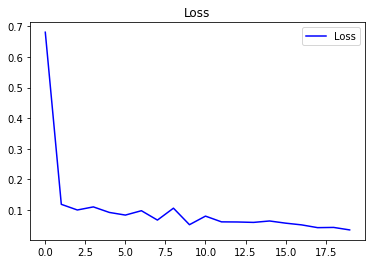

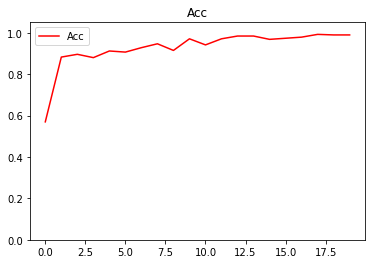

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

plt.title('Loss')
epochs=range(len(history.history["loss"])) # Get number of epochs
plt.plot(epochs,history.history["loss"],'b')
plt.legend(["Loss"])
plt.figure()

plt.title('Acc')
plt.ylim([0.0, 1.05])
plt.plot(epochs,history.history["accuracy"],'r')
plt.legend(["Acc"])
plt.figure()

#估计评分
scores = model.evaluate(x_test_padded_seqs,y_test,verbose = 0)
print(scores)